<a href="https://colab.research.google.com/github/TriNguyen2002/my-prj/blob/main/UR3_Inverse_Problem_Single_Solution_Brach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## UR3 robot document

https://people.ohio.edu/williams/html/PDF/UniversalRobotKinematics.pdf

# UR3 Inverse Kinematics (IK) With Machine Learning — Problem Summary

The goal is to train a neural network to approximate the inverse kinematics (IK)
of a UR3 6-DoF industrial robot. The network takes as input:

- End-effector position: (px, py, pz)
- End-effector orientation: quaternion (qw, qx, qy, qz)

and outputs:

- Joint angles θ1 … θ6

A direct IK mapping is fundamentally multi-valued. Many joint configurations
can produce the same end-effector pose:

- Shoulder-left / shoulder-right
- Elbow-up / elbow-down
- Wrist flip
- Quaternion q ≡ –q
- Angle periodicity: θ ≡ θ + 2π

Because the IK function is not one-to-one, a standard neural network
cannot learn this mapping unless the ambiguity is removed.



# Mathematical Foundations of UR3 IK

## Forward Kinematics (FK)

UR3 FK is computed using the Modified Denavit–Hartenberg (MDH) convention.
Each joint transform is:

$
T_i =
\begin{bmatrix}
\cos\theta_i & -\sin\theta_i \cos\alpha_i & \sin\theta_i \sin\alpha_i & a_i \cos\theta_i \\
\sin\theta_i & \cos\theta_i\cos\alpha_i & -\cos\theta_i\sin\alpha_i & a_i\sin\theta_i \\
0 & \sin\alpha_i & \cos\alpha_i & d_i \\
0 & 0 & 0 & 1
\end{bmatrix}
$

The overall pose is:

$
T = T_1 T_2 T_3 T_4 T_5 T_6
$

yielding:
- Position vector $ p \in \mathbb{R}^3 $
- Rotation matrix $ R \in SO(3) $

## Single-Branch Analytical IK

To avoid multi-valued ambiguity, we choose a consistent IK branch:

- Shoulder-left
- Elbow-down
- Wrist-up

Given end-effector pose (p, R):

1. Base rotation:
$
\theta_1 = \text{atan2}(p_y, p_x)
$

2. Wrist center:
$
w = p - d_6 R \hat{z}
$

3. Elbow geometry:
$
D = \frac{r^2 + s^2 - a_2^2 - a_3^2}{2 a_2 a_3}
$
$
\theta_3 = \arctan2\left(-\sqrt{1-D^2}, D\right)
$
$
\theta_2 = \phi - \psi
$

4. Wrist orientation:
$
R_{3\to6} = R_{0\to3}^T R_{target}
$
$
\theta_5 = \arctan2(\sqrt{R_{13}^2 + R_{23}^2}, R_{33})
$

This yields one consistent, continuous IK branch.



# Dataset Strategy for Learnable IK

Since IK is multi-valued, naive datasets break machine learning training.
To create a learnable mapping, we enforce:

$
T = FK(\theta_\text{rand})
$

$
\theta_\text{label} = IK_\text{single branch}(T)
$

This ensures:

- One unique IK output per pose
- Continuity across workspace
- No elbow-up/shoulder-right confusion
- No quaternion sign ambiguity
- No 2π periodicity error

Additionally:

- Input pose is normalized: $ x' = (x - \mu) / \sigma $
- Joint angles are encoded as `(sin θ, cos θ)` to eliminate discontinuities.

This yields a clean, single-valued function suitable for neural network training.
$

# Neural Network IK Model Description

We use a 4-layer fully connected MLP:

- Input: 7D pose (px, py, pz, qw, qx, qy, qz)
- Output: 12D (sinθ1…sinθ6, cosθ1…cosθ6)

Architecture:
- 4× hidden layers, 512 units each
- GELU activations
- LayerNorm
- Tanh output

Loss:
$
L = \frac{1}{N} \sum_i \| y_i - \hat{y}_i \|^2
$

Training details:
- Optimizer: Adam
- LR schedule: Cosine annealing
- Train/Test split: 90/10
- Epochs: 500

This architecture achieves millimeter-level position accuracy after training.


# Limitations

1. **Single IK branch only**
   - Only one (shoulder-left, elbow-down, wrist-up) solution is learned.
   - Other valid configurations are ignored.

2. **Instability near singularities**
   - Even single-branch IK can behave poorly near elbow singularities.

3. **Quaternion ambiguity**
   - Real-world quaternion inputs must be normalized to ensure consistency.

4. **No physical constraints**
   - No collision avoidance
   - No torque, velocity, or acceleration limits

5. **Not suitable for constrained optimization**
   - Model strictly maps pose → one IK solution, no reasoning about obstacles.


# Proposed Advanced Solutions

## 1. Mixture Density Networks (MDN)
Model all IK branches simultaneously:

$
p(\theta | T) = \sum_{k=1}^K \pi_k \, \mathcal{N}(\theta | \mu_k, \sigma_k)
$

Benefits:
- Handles all elbow-up/down, wrist-flip cases
- Best for whole-workspace coverage

## 2. Physics-Informed IK (PINN-IK)
Train model to output joint angles only:

$
L = \| FK(\theta) - p_{target} \|^2
$

Benefits:
- Does not require analytical IK
- No branch ambiguity
- Smooth and highly accurate

## 3. Hybrid IK (ML + Newton Refinement)
ML predicts initial guess; Newton-Raphson improves accuracy:

$
\theta_{k+1} = \theta_k + J^{-1}(T_{target} - FK(\theta_k))
$

Benefits:
- Very stable
- Industrial-grade precision

## 4. Trajectory Smoothing
For real robot use:

$
\theta_t^\text{smooth} = \alpha \theta_t + (1 - \alpha) \theta_{t-1}
$

Benefits:
- Eliminates joint jerks
- Perfect for continuous task-space motion


## Implementation

In [ ]:
# =====================================================================
# 0. Install dependencies
# =====================================================================
!pip install scipy

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(0)
torch.manual_seed(0)


# =====================================================================
# 1. UR3 Forward Kinematics (FK) with correct MDH
# =====================================================================
def dh(a, alpha, d, theta):
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    ct = np.cos(theta)
    st = np.sin(theta)
    return np.array([
        [ct, -st*ca,  st*sa, a*ct],
        [st,  ct*ca, -ct*sa, a*st],
        [0,      sa,     ca,    d],
        [0,       0,      0,    1]
    ])

def FK_UR3(q):
    # UR3 link lengths (meters)
    d1  = 0.1519
    a2  = -0.24365
    a3  = -0.21325
    d4  = 0.13105
    d5  = 0.08535
    d6  = 0.0921

    # UR3 offset-corrected joint angles
    q1 = q[0]
    q2 = q[1] + np.pi/2
    q3 = q[2]
    q4 = q[3] - np.pi/2
    q5 = q[4]
    q6 = q[5]

    T1 = dh(0,       np.pi/2, d1, q1)
    T2 = dh(a2,      0,       0,  q2)
    T3 = dh(a3,      0,       0,  q3)
    T4 = dh(0,       np.pi/2, d4, q4)
    T5 = dh(0,      -np.pi/2, d5, q5)
    T6 = dh(0,       0,       d6, q6)

    T = T1 @ T2 @ T3 @ T4 @ T5 @ T6

    pos = T[:3, 3]
    rot = R.from_matrix(T[:3, :3])
    quat = rot.as_quat()     # (x,y,z,w)
    quat = np.array([quat[3], quat[0], quat[1], quat[2]])  # → (w,x,y,z)

    return pos, quat


# =====================================================================
# 2. Single-branch analytical IK for UR3
#    (shoulder-left, elbow-down, wrist-up)
# =====================================================================
def IK_UR3_single_solution(pos, rot):
    """
    pos: (3,) xyz
    rot: (3,3) rotation matrix
    returns: (6,) joint angles or None if unreachable
    """
    px, py, pz = pos
    nx, ox, ax = rot[0]
    ny, oy, ay = rot[1]
    nz, oz, az = rot[2]

    d1  = 0.1519
    a2  = -0.24365
    a3  = -0.21325
    d4  = 0.13105
    d5  = 0.08535
    d6  = 0.0921

    # q1
    q1 = np.arctan2(py, px)

    # wrist center
    wx = px - d6 * ax
    wy = py - d6 * ay
    wz = pz - d6 * az

    r = np.sqrt(wx**2 + wy**2)
    s = wz - d1

    # q2, q3 via geometry
    D = (r*r + s*s - a2*a2 - a3*a3) / (2*a2*a3)
    if abs(D) > 1:
        return None  # unreachable

    # elbow-down branch
    q3 = np.arctan2(-np.sqrt(1 - D*D), D)

    phi = np.arctan2(s, r)
    psi = np.arctan2(a3*np.sin(q3), a2 + a3*np.cos(q3))
    q2 = phi - psi

    # build R0_3
    T1 = dh(0, np.pi/2, d1, q1)
    T2 = dh(a2, 0, 0, q2 + np.pi/2)
    T3 = dh(a3, 0, 0, q3)
    R0_3 = (T1 @ T2 @ T3)[:3, :3]

    R3_6 = R0_3.T @ rot

    # wrist-up
    q5 = np.arctan2(np.sqrt(R3_6[0,2]**2 + R3_6[1,2]**2), R3_6[2,2])
    q4 = np.arctan2(R3_6[1,2], R3_6[0,2])
    q6 = np.arctan2(R3_6[2,1], -R3_6[2,0])

    return np.array([q1, q2, q3, q4, q5, q6])


# =====================================================================
# 3. Generate dataset: Pose → One IK solution
# =====================================================================
N = 20000  # you can increase to 40k/60k later
poses = []
joints = []

print("Generating dataset...")

count = 0
attempts = 0

while count < N:
    attempts += 1
    if attempts > N * 30:
        print("Stopped early: too many rejects.")
        break

    # sample a random valid joint vector to generate pose
    q_rand = np.array([
        np.random.uniform(-2*np.pi,  2*np.pi),
        np.random.uniform(-2.0,      0.5),
        np.random.uniform(-2.0,      2.0),
        np.random.uniform(-3.0,      3.0),
        np.random.uniform(-2.0,      2.0),
        np.random.uniform(-3.0,      3.0),
    ])

    pos, quat = FK_UR3(q_rand)
    rot = R.from_quat([quat[1], quat[2], quat[3], quat[0]]).as_matrix()

    q_ik = IK_UR3_single_solution(pos, rot)
    if q_ik is None:
        continue

    poses.append(np.hstack([pos, quat]))
    joints.append(q_ik)
    count += 1

    if count % 2000 == 0:
        print(f"{count} / {N}")

poses = np.array(poses)
joints = np.array(joints)

print("Dataset shape:", poses.shape, joints.shape)




Generating dataset...
2000 / 20000
4000 / 20000
6000 / 20000
8000 / 20000
10000 / 20000
12000 / 20000
14000 / 20000
16000 / 20000
18000 / 20000
20000 / 20000
Dataset shape: (20000, 7) (20000, 6)


# Preprocessing data (Nomalized data)

In [ ]:

# =====================================================================
# 4. Prepare data for training
# =====================================================================
X = torch.tensor(poses, dtype=torch.float32)      # (N,7)
y = torch.tensor(joints, dtype=torch.float32)     # (N,6)

# normalize pose input
mean = X.mean(dim=0)
std = X.std(dim=0)
X_norm = (X - mean) / std
torch.save({"mean": mean, "std": std}, "normalization.pt")

# encode joint angles as sin/cos
def angles_to_sincos(theta):
    return torch.cat([torch.sin(theta), torch.cos(theta)], dim=1)  # (N,12)

y_sc = angles_to_sincos(y)

# train/test split
perm = torch.randperm(X_norm.size(0))
split = int(0.9 * len(perm))
train_idx = perm[:split]
test_idx  = perm[split:]

X_train = X_norm[train_idx]
y_train = y_sc[train_idx]
X_test  = X_norm[test_idx]
y_test  = y_sc[test_idx]

y_test_angles = y[test_idx]   # raw angles for error eval




# Training ML model

Training on: cuda
[0] Train=0.72508 | Test=0.26143
[10] Train=0.08675 | Test=0.08220
[20] Train=0.04908 | Test=0.04849
[30] Train=0.03408 | Test=0.03349
[40] Train=0.02595 | Test=0.02617
[50] Train=0.02154 | Test=0.02218
[60] Train=0.01880 | Test=0.01956
[70] Train=0.01709 | Test=0.01791
[80] Train=0.01590 | Test=0.01674
[90] Train=0.01503 | Test=0.01589
[100] Train=0.01438 | Test=0.01525
[110] Train=0.01395 | Test=0.01481
[120] Train=0.01368 | Test=0.01455
[130] Train=0.01354 | Test=0.01442
[140] Train=0.01348 | Test=0.01437
[150] Train=0.01348 | Test=0.01437
[160] Train=0.01347 | Test=0.01436
[170] Train=0.01342 | Test=0.01430
[180] Train=0.01328 | Test=0.01414
[190] Train=0.01301 | Test=0.01385
[200] Train=0.01260 | Test=0.01342
[210] Train=0.01207 | Test=0.01286
[220] Train=0.01146 | Test=0.01223
[230] Train=0.01082 | Test=0.01158
[240] Train=0.01020 | Test=0.01096
[250] Train=0.00962 | Test=0.01039
[260] Train=0.02676 | Test=0.02095
[270] Train=0.01479 | Test=0.01520
[280] Train=0

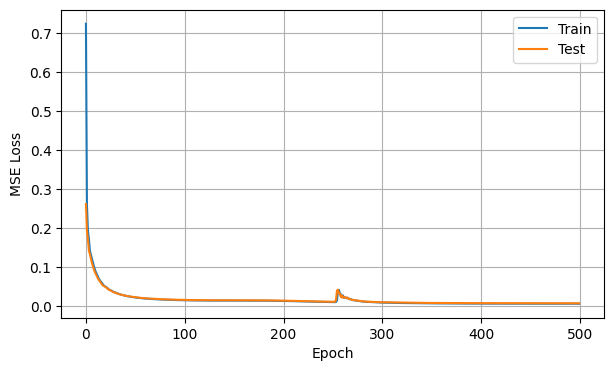

In [ ]:

# =====================================================================
# 5. Define IK MLP model
# =====================================================================
class IKNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(7, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 12),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Training on:", device)

model = IKNet().to(device)

X_train_dev = X_train.to(device)
y_train_dev = y_train.to(device)
X_test_dev  = X_test.to(device)
y_test_dev  = y_test.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)
criterion = nn.MSELoss()


# =====================================================================
# 6. Training loop
# =====================================================================
epochs = 500
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    pred = model(X_train_dev)
    loss = criterion(pred, y_train_dev)
    loss.backward()
    optimizer.step()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_test_dev), y_test_dev).item()

    train_losses.append(loss.item())
    test_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f"[{epoch}] Train={loss.item():.5f} | Test={val_loss:.5f}")

torch.save(model.state_dict(), "ik_single_solution.pth")
print("Training complete!")


# =====================================================================
# 7. Plot loss curves
# =====================================================================
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()



# Prediction

In [ ]:

# =====================================================================
# 8. Inference helper: pose(7) -> joint(6)
# =====================================================================
def ik_predict(pose7, model, device):
    model.eval()
    pose7 = torch.tensor(pose7, dtype=torch.float32)
    norm = torch.load("normalization.pt")
    pose_norm = (pose7 - norm["mean"]) / norm["std"]

    with torch.no_grad():
        pred = model(pose_norm.to(device)).cpu()

    sin_vals = pred[:6]
    cos_vals = pred[6:]
    angles = torch.atan2(sin_vals, cos_vals).numpy()
    return angles


# =====================================================================
# 9. Error evaluation: angle error + FK position/orientation error
# =====================================================================
def wrap_to_pi(a):
    return (a + np.pi) % (2*np.pi) - np.pi

model_cpu = model.to("cpu")  # move to CPU for eval
mean_np = mean.numpy()
std_np  = std.numpy()

num_eval = min(2000, X_test.shape[0])
idx_eval = np.random.choice(X_test.shape[0], size=num_eval, replace=False)

angle_errors_deg = []
pos_errors_mm = []
ori_errors = []

for idx in idx_eval:
    pose_norm = X_test[idx].numpy()
    pose = pose_norm * std_np + mean_np   # de-normalize

    pos_true = pose[:3]
    quat_true = pose[3:]

    q_true = y_test_angles[idx].numpy()

    q_pred = ik_predict(pose, model_cpu, device="cpu")

    # angle error (wrapped)
    q_true_w = wrap_to_pi(q_true)
    q_pred_w = wrap_to_pi(q_pred)
    angle_err = np.abs(q_pred_w - q_true_w)
    angle_errors_deg.extend(np.rad2deg(angle_err))

    # FK-based pose error
    pos_pred, quat_pred = FK_UR3(q_pred)
    pos_err = np.linalg.norm(pos_pred - pos_true)   # in meters
    pos_errors_mm.append(pos_err * 1000.0)          # convert to mm

    # orientation error 1 - |dot(q_pred, q_true)|
    dot = np.abs(np.dot(quat_pred, quat_true))
    ori_err = 1.0 - np.clip(dot, 0.0, 1.0)
    ori_errors.append(ori_err)



# Quick sanity check on a single pose
test_pose = poses[0]
q_pred_example = ik_predict(test_pose, model_cpu, device="cpu")
print("\nExample:")
print("True q:", joints[0])
print("Pred q:", q_pred_example)


Example:
True q: [-1.27987126 -2.99845556 -1.17566291  1.07371615  1.13004816  2.77196465]
Pred q: [-1.2983614 -3.001635  -1.1257672  1.0380903  1.1573619  2.6477475]
